In [11]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import networkx as nx
from sklearn.preprocessing import MinMaxScaler


warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Preprocessing

In [2]:
df = pd.read_csv('trips.csv')

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1469851 entries, 0 to 1469850
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   Unnamed: 0         1469851 non-null  int64 
 1   Rental Id          1469851 non-null  int64 
 2   Duration           1469851 non-null  int64 
 3   Bike Id            1469851 non-null  int64 
 4   End Date           1469851 non-null  object
 5   EndStation Id      1469851 non-null  int64 
 6   EndStation Name    1469851 non-null  object
 7   Start Date         1469851 non-null  object
 8   StartStation Id    1469851 non-null  int64 
 9   StartStation Name  1469851 non-null  object
dtypes: int64(6), object(4)
memory usage: 112.1+ MB


In [15]:
df_test = pd.read_csv('extract1.csv')

In [3]:
def check_df(df, head=5):
    print('########## SHAPE ##########')
    print(df.shape)
    print('########## INFO ##########')
    print(df.info())
    print('########## DESCRIBE ##########')
    print(df.describe().T)
    print('########## HEAD ##########')
    print(df.head(head))
    print('########## NA ##########')
    print(df.isnull().sum())

In [5]:
check_df(df)

########## SHAPE ##########
(1469851, 10)
########## INFO ##########
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1469851 entries, 0 to 1469850
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   Unnamed: 0         1469851 non-null  int64 
 1   Rental Id          1469851 non-null  int64 
 2   Duration           1469851 non-null  int64 
 3   Bike Id            1469851 non-null  int64 
 4   End Date           1469851 non-null  object
 5   EndStation Id      1469851 non-null  int64 
 6   EndStation Name    1469851 non-null  object
 7   Start Date         1469851 non-null  object
 8   StartStation Id    1469851 non-null  int64 
 9   StartStation Name  1469851 non-null  object
dtypes: int64(6), object(4)
memory usage: 112.1+ MB
None
########## DESCRIBE ##########
                      count         mean        std          min          25%  \
Unnamed: 0      1469851.000   734926.000 424309.580        1.

In [3]:
def preprocessing(df, exclude_weekends: bool = True):
    # rename all columns that have spaces in them to have underscores instead

    df.columns = df.columns.str.replace(' ', '_')

    # convert the date column to datetime format

    df['Start_Date'] = pd.to_datetime(df['Start_Date'])
    df['End_Date'] = pd.to_datetime(df['End_Date'])

    # drop uname column
    df.drop('Unnamed:_0', axis=1, inplace=True)

    # create a new column that gets the duration of the trip in minutes 
    df['Duration_MIN'] = (df['End_Date'] - df['Start_Date']).dt.total_seconds() / 60

    # drops rows where it is a weekend trip

    if exclude_weekends:
        df = df[~df['Start_Date'].dt.day_name().isin(['Saturday', 'Sunday'])]
        df = df[~df['End_Date'].dt.day_name().isin(['Saturday', 'Sunday'])]   

    # create feature that gets the trip frequency for future use in the graph community detection

    trip_freq = df.groupby(['StartStation_Id', 'EndStation_Id']).size().reset_index(name='Trip_Frequency')

    # Merge trip frequency with the original dataframe
    df = pd.merge(df, trip_freq, on=['StartStation_Id', 'EndStation_Id'], how='left')
    
    # create feature that gets the weighted edge for future use in the graph community detection
    
    df['Weighted_Edge'] = (df['Duration_MIN'] * 0.2) + (df['Trip_Frequency'] * 0.8)
        
    return df

In [4]:
df = preprocessing(df)

In [5]:
df.head()

,Rental_Id,Duration,Bike_Id,End_Date,EndStation_Id,EndStation_Name,Start_Date,StartStation_Id,StartStation_Name,Duration_MIN,Trip_Frequency,Weighted_Edge
0,34225975,300,5893,2014-06-23 00:05:00,70,"Calshot Street , King's Cross",2014-06-23,70,"Calshot Street , King's Cross",5.000,32,26.600
1,34225978,720,1245,2014-06-23 00:12:00,503,"Cleveland Way, Bethnal Green",2014-06-23,498,"Bow Road Station, Bow",12.000,11,11.200
2,34225979,600,5840,2014-06-23 00:10:00,723,"Stephendale Road, Sands End",2014-06-23,680,"Westbridge Road, Battersea",10.000,20,18.000
3,34225976,900,4358,2014-06-23 00:15:00,589,"Drayton Gardens, Chelsea",2014-06-23,723,"Stephendale Road, Sands End",15.000,3,5.400
4,34225977,900,12055,2014-06-23 00:15:00,589,"Drayton Gardens, Chelsea",2014-06-23,723,"Stephendale Road, Sands End",15.000,3,5.400


In [6]:
df_EDA = df.copy()

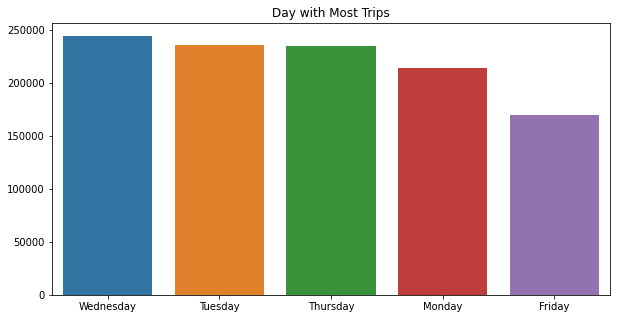

In [7]:
# get the week of day with most trips

plt.figure(figsize=(10, 5))
sns.barplot(x=df_EDA['Start_Date'].dt.day_name().value_counts().index, y=df_EDA['Start_Date'].dt.day_name().value_counts().values)
plt.title('Day with Most Trips')
plt.show()

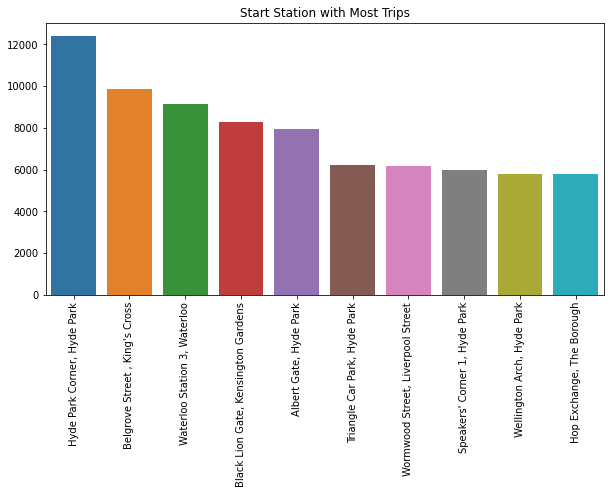

In [8]:
# create EDA plot for the start station

plt.figure(figsize=(10, 5))
sns.barplot(x=df_EDA['StartStation_Name'].value_counts().head(10).index, y=df_EDA['StartStation_Name'].value_counts().head(10).values)
plt.title('Start Station with Most Trips')
plt.xticks(rotation=90)
plt.show()



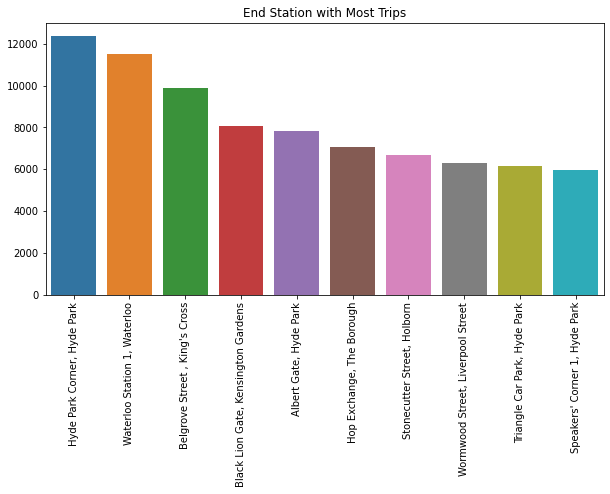

In [28]:
# create EDA plot for the start station

plt.figure(figsize=(10, 5))
sns.barplot(x=df_EDA['EndStation_Name'].value_counts().head(10).index, y=df_EDA['EndStation_Name'].value_counts().head(10).values)
plt.title('End Station with Most Trips')
plt.xticks(rotation=90)
plt.show()


In [29]:
# create a feature that is called "Sub_Borough" that is what comes after the first comma in StartStation_Name and EndStation_Name

df_EDA['StartStation_Sub_Borough'] = df_EDA['StartStation_Name'].str.split(',').str[1]
df_EDA['EndStation_Sub_Borough'] = df_EDA['EndStation_Name'].str.split(',').str[1]



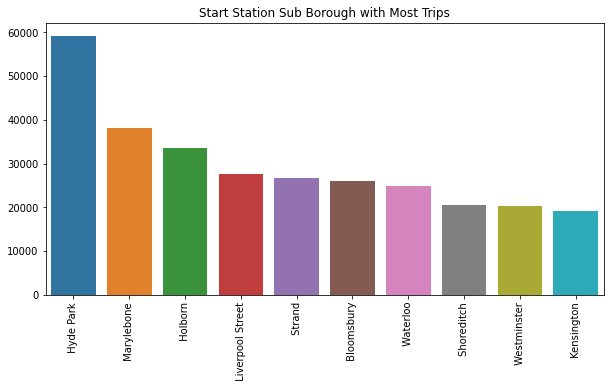

In [31]:
# create EDA plot for the start station sub borough 

plt.figure(figsize=(10, 5))
sns.barplot(x=df_EDA['StartStation_Sub_Borough'].value_counts().head(10).index, y=df_EDA['StartStation_Sub_Borough'].value_counts().head(10).values)
plt.title('Start Station Sub Borough with Most Trips')
plt.xticks(rotation=90)
plt.show()

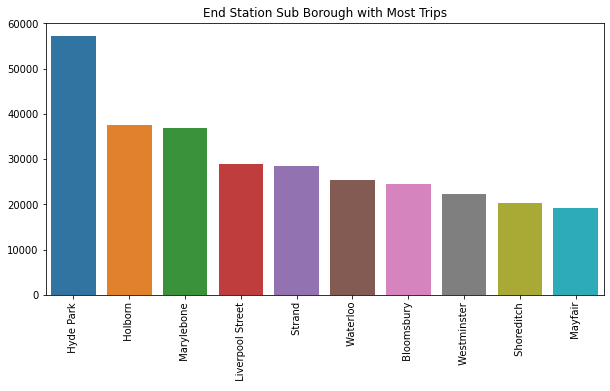

In [32]:
# create EDA plot for the end station sub borough

plt.figure(figsize=(10, 5))
sns.barplot(x=df_EDA['EndStation_Sub_Borough'].value_counts().head(10).index, y=df_EDA['EndStation_Sub_Borough'].value_counts().head(10).values)
plt.title('End Station Sub Borough with Most Trips')
plt.xticks(rotation=90)
plt.show()


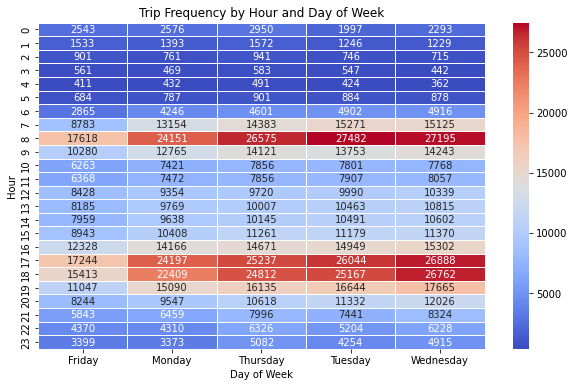

In [42]:
# pivot table to get trip frequency by day of week and hour
trip_freq_by_hour = df_EDA.pivot_table(values='Rental_Id', index=df_EDA['Start_Date'].dt.hour, columns=df_EDA['Start_Date'].dt.day_name(), aggfunc='count')

# create heatmap
plt.figure(figsize=(10,6))
sns.heatmap(trip_freq_by_hour, linewidths=.5, annot=True, fmt='g', cmap= 'coolwarm')
plt.title('Trip Frequency by Hour and Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Hour')
plt.show()

## Louvain Clustering (Community Detection)

The choice of edge attribute to use in the Louvain clustering algorithm can depend on the specific problem you are trying to solve and the available data. In the case of bike-sharing data, the duration of a trip could be a relevant feature to use as an edge attribute for community detection. However, there may be other attributes that are also informative for identifying community structure, such as the frequency of trips between stations or the number of unique riders using a station pair.

If you have access to additional data or features, it may be worth exploring different edge attributes and evaluating their performance in community detection. It could also be useful to consider combining multiple attributes into a single weighted edge, for example, by computing a weighted average of different features.

In summary, while duration of trips can be a good attribute to use for community detection in bike-sharing data, it is important to consider other potential attributes and evaluate their performance in clustering algorithms.

In [12]:
import matplotlib.cm as cm
import community as community_louvain
import networkx as nx
import pandas as pd


def louvain_clustering(df, plot_graph=True):
    """
    Perform Louvain clustering for community detection on a given graph.

    Parameters:
    -----------
    df : pandas.DataFrame
        A pandas DataFrame containing the graph data with 'StartStation_Id',
        'EndStation_Id', and 'Duration_MIN' columns.
    plot_graph : bool, default=True
        Whether to plot the graph with node colors based on communities.

    Returns:
    --------
    partition_df : pandas.DataFrame
        A pandas DataFrame containing the partition information with 'Station'
        and 'Community' columns.
    """

    # implment random seed

    np.random.seed(14)

    # Create an empty DataFrame to store the partition information
    partition_df = pd.DataFrame(columns=['Station', 'Community'])

    # Create a graph from the DataFrame
    G = nx.from_pandas_edgelist(df, source='StartStation_Id', target='EndStation_Id', edge_attr='Weighted_Edge')

    # Find the best partition using the Louvain algorithm
    partition = community_louvain.best_partition(G)

    print(partition)

    # Add the partition information to the DataFrame
    partition_df['Station'] = partition.keys()
    partition_df['Community'] = partition.values()

    # Indicate the proportion of nodes in each community
    community_ratio = partition_df['Community'].value_counts(normalize=True)
    print(f'The proportion of nodes in each community is:\n{community_ratio}')

    print('------------------------------------')

    
    # print the modularity score

    modularity_score = community_louvain.modularity(partition, G)

    print(f'The modularity score is : {modularity_score}')

    print('------------------------------------')


    # Create a list of colors for the communities
    colors = [cm.rainbow(float(i) / max(partition_df['Community'])) for i in partition_df['Community']]


    # node size

    node_size = [G.degree(node) * 2 for node in G.nodes()] 

    # Plot the graph with node colors based on communities

    if plot_graph:
            #pos = nx.spring_layout(G)
            plt.figure(figsize=(20, 10))
            nx.draw(G, node_color=colors, with_labels=True, alpha=0.8, width=0.2)
            #nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=colors)
            #nx.draw_networkx_labels(G, pos, font_size=8)
            #plt.axis('off')
            plt.show()

    return partition_df

In [13]:
# used in TP5
def GetInfoGraph(G):
    print('number of edges', G.number_of_edges())
    print('number of nodes', G.number_of_nodes())
    print('min degree', np.min([degree[1] for degree in G.degree()])) # minimum degree
    print('max degree', np.max([degree[1] for degree in G.degree()]))# maximum degree
    #print('VERTICES', G.nodes())
    #print('EDGES', G.edges())
    print('Is connected ?', nx.is_connected(G))
    print('number of connected components: ', nx.number_connected_components(G))
    nx.draw(G, with_labels =True)



number of edges 121149
number of nodes 750
min degree 31
max degree 620
Is connected ? True
number of connected components:  1


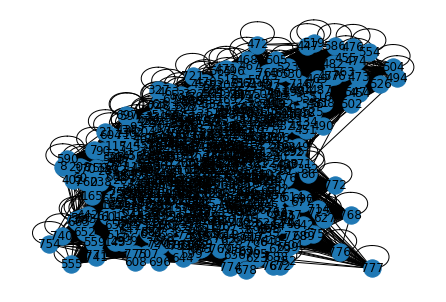

In [14]:
G = nx.from_pandas_edgelist(df, source='StartStation_Id', target='EndStation_Id', edge_attr='Weighted_Edge')

GetInfoGraph(G)

{70: 1, 498: 1, 503: 1, 680: 0, 723: 0, 589: 0, 214: 1, 68: 1, 669: 3, 270: 3, 278: 1, 33: 1, 383: 3, 524: 0, 336: 1, 334: 1, 236: 1, 501: 1, 56: 2, 80: 1, 500: 1, 491: 1, 649: 0, 651: 0, 507: 1, 206: 1, 604: 2, 320: 0, 102: 1, 732: 1, 553: 1, 495: 1, 24: 1, 11: 1, 405: 0, 277: 0, 67: 1, 40: 1, 574: 1, 492: 1, 698: 1, 283: 1, 696: 0, 635: 0, 372: 1, 246: 1, 126: 1, 101: 1, 573: 0, 729: 0, 89: 1, 757: 0, 175: 1, 298: 1, 3: 1, 564: 1, 199: 1, 504: 1, 686: 0, 153: 0, 194: 1, 594: 1, 440: 3, 156: 1, 547: 1, 525: 1, 706: 1, 645: 1, 598: 0, 643: 0, 14: 1, 133: 0, 428: 0, 566: 0, 663: 0, 96: 1, 77: 1, 16: 1, 664: 0, 268: 0, 755: 0, 597: 0, 656: 0, 216: 0, 654: 3, 650: 0, 151: 0, 217: 1, 488: 1, 10: 1, 354: 3, 646: 0, 275: 1, 54: 1, 213: 0, 591: 0, 464: 1, 462: 1, 103: 0, 770: 0, 39: 1, 465: 1, 225: 0, 761: 0, 715: 1, 552: 1, 22: 1, 146: 0, 221: 3, 23: 1, 477: 1, 109: 2, 31: 1, 135: 1, 112: 1, 395: 0, 239: 2, 374: 3, 549: 1, 261: 0, 252: 3, 583: 3, 711: 0, 381: 2, 50: 1, 443: 1, 450: 1, 745: 0

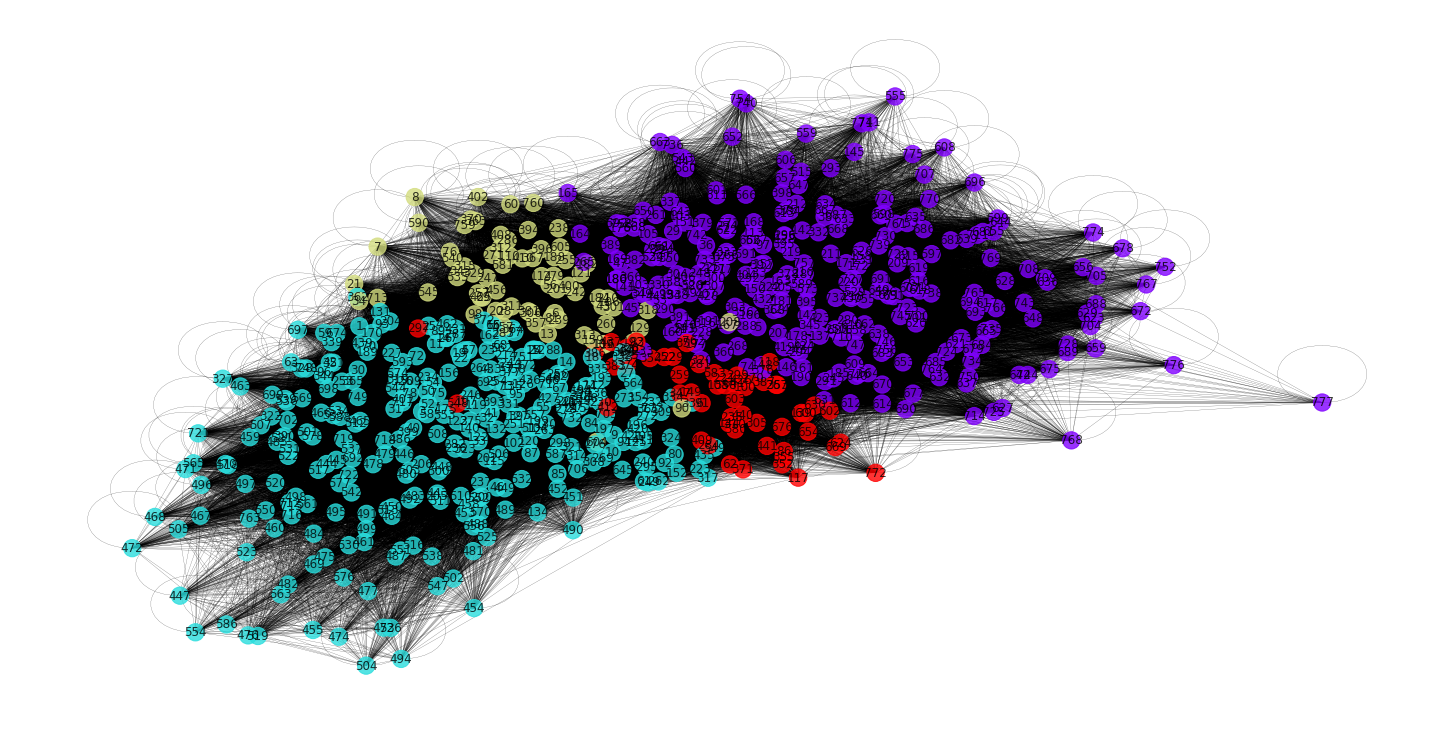

In [40]:
df_louvain = louvain_clustering(df, plot_graph=True)

In [17]:
from networkx.algorithms import community

def girvan_newman_clustering(df, plot_graph=True):
    """
    Perform Girvan-Newman clustering for community detection on a given graph.

    Parameters:
    -----------
    df : pandas.DataFrame
        A pandas DataFrame containing the graph data with 'StartStation_Id',
        'EndStation_Id', and 'Duration_MIN' columns.
    plot_graph : bool, default=True
        Whether to plot the graph with node colors based on communities.

    Returns:
    --------
    partition_df : pandas.DataFrame
        A pandas DataFrame containing the partition information with 'Station'
        and 'Community' columns.
    """

    # Create an empty DataFrame to store the partition information
    partition_df = pd.DataFrame(columns=['Station', 'Community'])

    # Create a graph from the DataFrame
    G = nx.from_pandas_edgelist(df, source='StartStation_Id', target='EndStation_Id', edge_attr='Weighted_Edge')

    # Find the connected components of the graph
    components = [c for c in nx.connected_components(G)]

    # Continue until the graph is fully disconnected
    while len(components) == 1:
        # Calculate the betweenness centrality of the edges
        bc = nx.edge_betweenness_centrality(G)

        # Remove the edge with the highest betweenness centrality
        edge = max(bc.items(), key=lambda x: x[1])[0]
        G.remove_edge(*edge)

        # Find the connected components of the remaining graph
        components = [c for c in nx.connected_components(G)]

    # Add the partition information to the DataFrame
    for i, c in enumerate(components):
        partition_df = partition_df.append(pd.DataFrame({'Station': list(c), 'Community': i}))

    # Indicate the proportion of nodes in each community
    community_ratio = partition_df['Community'].value_counts(normalize=True)
    print(f'The proportion of nodes in each community is:\n{community_ratio}')

    print('------------------------------------')

    # Calculate the modularity score
    modularity_score = community.modularity(partition_df['Community'], G)
    print(f'The modularity score is: {modularity_score}')

    print('------------------------------------')

    # Create a list of colors for the communities
    colors = [cm.rainbow(float(i) / max(partition_df['Community'])) for i in partition_df['Community']]

    # Plot the graph with node colors based on communities
    if plot_graph:
        plt.figure(figsize=(20, 10))
        nx.draw(G, node_color=colors, with_labels=True, alpha=0.8, width=0.2)
        plt.show()

    return partition_df


In [18]:
df_girvan_newman = girvan_newman_clustering(df, plot_graph=True)

KeyboardInterrupt: 

In [19]:
# Exercise 1.1
def girvan_newman_algorithm(G):
    '''
    :param G: given graph
    :return partitions: a list tuples of sets of nodes in the graph. Each node set indicates a community and
    each tuple is a sequence of communities at a certain level of the algorithm.
    '''
    g = G.copy()
    partitions = []
    size=1
    
    # Repeat below process until one edge left
    while len(g.edges) > 0:
        
        # Compute betweeness centrality for every edges - use shortest path 
        ebc = nx.edge_betweenness_centrality(g)
    
        # Remove edge with highest centrality
        edge = max(ebc, key=ebc.get)
        g.remove_edge(edge[0], edge[1]) 
    
        # Retrieve communities with this edge removal
        # communities = [c for c in sorted(nx.connected_components(g), key=len, reverse=True)]
        communities = list(nx.connected_components(g))
        
        # Update partitions if communities have changed
        if len(communities) != size: 
            partitions.append(communities)
            size += 1
        
    # Use below dendograms to learn when to stop 
    return partitions

In [21]:
G = nx.from_pandas_edgelist(df, source='StartStation_Id', target='EndStation_Id', edge_attr='Weighted_Edge')

partitions = girvan_newman_algorithm(G)

KeyboardInterrupt: 

In [ ]:
def compute_modularity(G, partition):
    '''
    :param G: given graph
    :param partition: a tuple of node sets.
    :return result: modularity value for a given partition of the network.
    '''    
    num_of_edges = G.number_of_edges()
    modularity_list = []
    
    # Loop over communities
    for subset in partition:
        nodelist = list(subset)
        G_subset = G.subgraph(nodelist)
        A = nx.adj_matrix(G_subset)
        
        s = 0
        # For all pair of nodes inside these communities
        for i in range(G_subset.number_of_nodes()):
            for j in range(G_subset.number_of_nodes()):
                s += A[i, j] - ( ( nx.degree(G, nodelist[i])*nx.degree(G, nodelist[j]) ) / (2.0*num_of_edges) )
            
        modularity_list.append(s / (2.0*num_of_edges))
            
    return np.sum(modularity_list)

In [ ]:
import infomap
import pandas as pd
import networkx as nx

def infomap_clustering(df, plot_graph=True):
    """
    Perform Infomap clustering for community detection on a given graph.

    Parameters:
    -----------
    df : pandas.DataFrame
        A pandas DataFrame containing the graph data with 'StartStation_Id',
        'EndStation_Id', and 'Duration_MIN' columns.
    plot_graph : bool, default=True
        Whether to plot the graph with node colors based on communities.

    Returns:
    --------
    partition_df : pandas.DataFrame
        A pandas DataFrame containing the partition information with 'Station'
        and 'Community' columns.
    """

    # Create an empty DataFrame to store the partition information
    partition_df = pd.DataFrame(columns=['Station', 'Community'])

    # Create a graph from the DataFrame
    G = nx.from_pandas_edgelist(df, source='StartStation_Id', target='EndStation_Id', edge_attr='Weighted_Edge')

    # Create an Infomap object
    im = infomap.Infomap()

    # Add edges to the Infomap object
    for edge in G.edges():
        im.addLink(str(edge[0]), str(edge[1]))

    # Run the Infomap algorithm
    im.run()

    # Add the partition information to the DataFrame
    for node in im.iterTree():
        if node.isLeaf():
            partition_df = partition_df.append({'Station': node.physicalId, 'Community': node.moduleIndex()}, ignore_index=True)

    # Indicate the proportion of nodes in each community
    community_ratio = partition_df['Community'].value_counts(normalize=True)
    print(f'The proportion of nodes in each community is:\n{community_ratio}')

    print('------------------------------------')

    # Create a list of colors for the communities
    colors = [cm.rainbow(float(i) / max(partition_df['Community'])) for i in partition_df['Community']]

    # node size
    node_size = [G.degree(node) * 2 for node in G.nodes()]

    # Plot the graph with node colors based on communities
    if plot_graph:
        plt.figure(figsize=(20, 10))
        nx.draw(G, node_color=colors, with_labels=True, alpha=0.8, width=0.2)
        plt.show()

    return partition_df


In [ ]:
import cudf
import cugraph

# import the data from the csv file

df = cudf.read_csv('data/2017-fordgobike-tripdata.csv')

# create a graph from the data

G = cugraph.Graph()

G.from_cudf_edgelist(df, source='StartStation_Id', destination='EndStation_Id', edge_attr='Weighted_Edge')

In [ ]:
# def a girvan_newman clustering function with cugraph

def cugraph_girvan_newman_clustering(G, plot_graph=True):
    """
    Perform Girvan-Newman clustering for community detection on a given graph.

    Parameters:
    -----------
    G : cugraph.Graph
        A cugraph.Graph object containing the graph data.
    plot_graph : bool, default=True
        Whether to plot the graph with node colors based on communities.

    Returns:
    --------
    partition_df : cudf.DataFrame
        A cudf.DataFrame containing the partition information with 'Station'
        and 'Community' columns.
    """

    # Create an empty DataFrame to store the partition information
    partition_df = cudf.DataFrame(columns=['Station', 'Community'])

    # Run the Girvan-Newman algorithm
    df, mod = cugraph.leiden(G)

    # Add the partition information to the DataFrame
    partition_df['Station'] = df['vertex']
    partition_df['Community'] = df['partition']

    # Indicate the proportion of nodes in each community
    community_ratio = partition_df['Community'].value_counts(normalize=True)
    print(f'The proportion of nodes in each community is:\n{community_ratio}')

    print('------------------------------------')

    # Calculate the modularity score
    modularity_score = community.modularity(partition_df['Community'], G)
    print(f'The modularity score is: {modularity_score}')

    print('------------------------------------')

    # Create a list of colors for the communities
    colors = [cm.rainbow(float(i) / max(partition_df['Community'])) for i in partition_df['Community']]

    # Plot the graph with node colors based on communities
    if plot_graph:
        plt.figure(figsize=(20, 10))
        nx.draw(G, node_color=colors, with_labels=True, alpha=0.8, width=0.2)
        plt.show()

    return partition_df

In [ ]:
# apply preprocessing function to the data cudf dataframe

df = preprocessing(df)

# create a graph from the data

G = cugraph.Graph()

G.from_cudf_edgelist(df, source='StartStation_Id', destination='EndStation_Id', edge_attr='Weighted_Edge')

# run the clustering algorithm

partition_df = cugraph_girvan_newman_clustering(G)

